https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

In [ ]:
"""
PCA(Principal component analysis)
n차원의 공간은 국부적으로 n-1차원의 초평면(hyperplane)로 나타낼 수 있으며
이를 n-1차원 매니폴드라고 한다. 주성분 분석은 이때 n차원을 가장 잘 설명할 수 있는
(분산이 최대로 보존되는 혹은 정보가 가장 적게 손실되는)
n-1차원의 초평면에 n차원 데이터들을 투영하는 것을 반복하여 고차원 공간을 저차원으로 설명하는 기법이다.
이때 저차원으로 투영하는 것을 반복할때 i번째 축을 i번째 주성분(Principal compenent)라고 하며
이 주성분은 특잇값 분해(SVD)를 통하여 구해지고, 많은 양의 정보를 설명할 수 있는 주성분 순서대로 정렬된다.
(pca.explained.variance_ratio_를 통해 확인 가능)
"""
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

mnist = fetch_openml('mnist_784', as_frame = False, parser = 'auto')
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

pca = PCA(n_components = 0.95) # 원본 데이터 분산의 95%를 설명하는 차원으로 자동 설정
X_reduced = pca.fit_transform(X_train)

In [5]:
# 784차원 -> 154차원 축소
pca.n_components_

154

In [ ]:
# 95% 데이터 복원
X_reduced = pca.inverse_transform(X_train)

In [10]:
"""
다음과 같이 차원 수를 그리드 서치할 수 있다.
"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80), # range(10, 80) 과 같음.
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20,
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [11]:
rnd_search.best_params_
# {'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}
# 784 -> 57차원으로 축소
# n_iter와 data를 늘리면 아래까지 줄일 수도 있다.
# {'randomforestclassifier__n_estimators': 272, 'pca__n_components': 28}

{'randomforestclassifier__n_estimators': 272, 'pca__n_components': 28}

In [13]:
"""
특잇값 분해(SVD)방법을 선택할 수 있다.
보통의 경우 auto로 두고 사용하면 되며, 정확한 결과를 얻고싶은 경우
svd_solver = 'full'로 지정할 수 있지만, 오래 걸릴 수 있다.
"""
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized' , random_state = 42)
X_reduce = rnd_pca.fit_transform(X_train)

In [23]:
"""
PCA의 단점 중 하나는 SVD를 위해서 전체 훈련 세트를 메모리에 올려야 한다는 점이다.
대용량 데이터셋에서는 이것이 어려울 수 있으므로 IncrementalPCA를 사용한다.
IncrementalPCA는 데이터셋을 미니배치로 나누어서 학습하기 때문에 메모리 면에서
효율적이며 온라인 학습도 가능하게 한다.
"""
from sklearn.decomposition import IncrementalPCA

n_batches = 100 # 훈련 세트를 나눌 단위
inc_pca = IncrementalPCA(n_components = 154)

# (60000, 784)크기의 X_train이 [[600] * 100]으로 쪼개진다.
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train) # (60000,154)로 바뀐다.
X_reduced.shape
"""
데이터를 메모리에 저장하지 않고 파일로 만든 다음
조금씩 불러오면서 사용할 수도 있다.

filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # 대신 루프를 사용하여 데이터를 청크 단위로 저장할 수 있습니다.
X_mmap.flush()

# 원시 이진 데이터만 디스크에 저장되므로 불러올때 데이터 타입과 배열의 크기를 지정해야함.
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size = batch_size)
inc_pca.fit(X_mmap) # 일반적인 fit 메서드를 사용할 수 있다.
"""

In [ ]:
"""
그러나 랜덤PCA경우에도 계산 복잡도는 O(m * d^2) + O(d^3) 이므로
이미지처럼 수만 개 이상의 특성이 있으면 계산이 매우 느려진다.
따라서 이럴때는 랜덤투영(랜덤인데도 의외로 잘 먹힘)을 사용해야 한다.
"""
from sklearn.random_projection import GaussianRandomProjection

X = np.random.randn(5000, 20000)

gaussian_rnd_proj = GaussianRandomProjection(eps = 0.1, random_state = 42)
X_reduced = gaussian_rnd_proj.fit_transform(X) # (5000, 7300)


In [ ]:
"""
SparseRandomProjection은 희소한 랜덤 행렬을 생성하여 매우 적은 메모리와
빠른 속도로 GaussianRandomProjection과 비슷한 성능을 낼 수 있다.
따라서 규모가 크거나, 희소한(?) 데이터 셋의 경우 이걸 써야한다.
실제로 위 코드는 1분정도 소요되는데 이건 12초만에 완료됨.
"""
from sklearn.random_projection import SparseRandomProjection

sparse_rnd_proj = SparseRandomProjection(eps = 0.1, random_state = 42)
X_reduced = sparse_rnd_proj.fit_transform(X) # (5000, 7300)


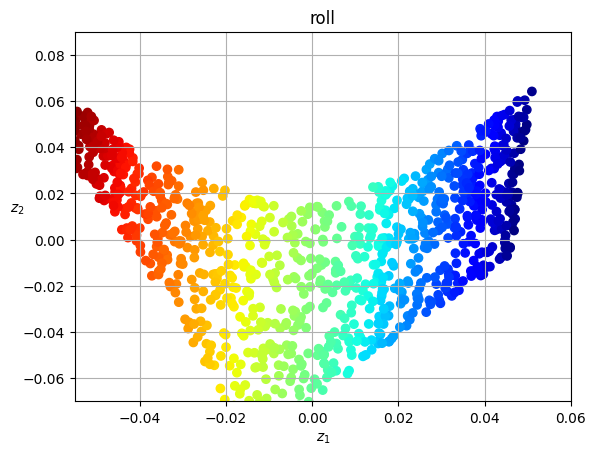

In [52]:
"""
지역 선형 임베딩(LLE; Locally Linear Embedding)
PCA나 랜덤투영처럼 투영에 의존하지 않는 매니폴드 학습으로
비선형 차원 축소(NLDR; Nonlieanr Dimensionality reduction)기술이다.
잡음이 너무 많지 않은 경우 꼬인 매니폴드를 푸는데 효과적이다.
1. 어떤 샘플로부터 k개의 최근접 이웃을 찾고, 2. 이웃에 대한 가중치 계산,
3. 고차원 임베딩 4. 저차원으로 매핑의 단계를 거쳐서 차원 축소가 일어나는데
저차원 표현을 만드는데 O(dm^2)의 시간복잡도가 필요하므로
대규모 데이터셋에서는 사용할 수 없다.
"""
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap='jet')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("roll")
plt.show()

In [62]:
test_data = np.random.rand(1000,1000)

pca = PCA(n_components = 0.95) # 원본 데이터 분산의 95%를 설명하는 차원으로 자동 설정
X_reduced = pca.fit_transform(test_data)

In [63]:
X_reduced.shape

(1000, 610)